In [ ]:
import os
# homedir = os.path.realpath(__file__)[:-len('Notebooks/KM3NoTebook.ipynb')]
homedir = os.getcwd()[:-len('Notebooks')]
import sys
sys.path.append("..") # Needed to import files
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import ticker
from scipy.stats import gamma

import MyUnits as muns
import MyFunctions as mfuns
import PlottingVariables as plvars
cmp = 1./2.54 # centimeters to inches for plotting
import Parameters as pars

from scipy import integrate
from scipy.optimize import minimize

import Experiments.ANITA as AN
import Calculators.Probabilities as probs
import Experiments.KM3NeT as K3
import Experiments.KM3NeT as K3s
import Experiments.IceCube as IC
import JointFits.ANITApK3pIC as A3

from mpl_toolkits.axes_grid1 import make_axes_locatable

pt_to_cm = 0.0351459804
cm_to_in = 0.3937008
lat_textwidth_pt = 426.79135 #pt #523.5307 #pt

tw = 7.788 # textwidth, in inches

lat_linewidth = 246.0*pt_to_cm*cm_to_in
lat_textwidth = lat_textwidth_pt*pt_to_cm*cm_to_in
golden_ratio = 1.61803

# print(tw, lat_textwidth)
# fig_x = lat_textwidth*pt_to_cm*cm_to_in*0.95 # Size of the full page figure in inches
# fig_y = fig_x/golden_ratio

width_1plot = lat_textwidth*0.8
height_1plot = width_1plot/golden_ratio
figsize_1plot=(width_1plot,height_1plot)

width_1plot_22axis = lat_textwidth*0.85
height_1plot_22axis = width_1plot_22axis/golden_ratio
figsize_1plot_22axis =(width_1plot_22axis,height_1plot_22axis)

plotdir  = homedir + 'Figures/'
plotdirK = homedir + 'Figures/KM3NeT/'
datadir  = homedir + "PlotData/"
datadirK = homedir + "Data/KM3NeT/"
datadirA = homedir + "Data/ANITA/"
datadirI = homedir + "Data/IceCube/"

plt.style.use(homedir+'PlotData/style.mplstyle')
matplotlib.rcParams.update({'text.usetex': True})
matplotlib.rcParams['text.latex.preamble']=r"\usepackage{amsmath}"
matplotlib.rcParams['figure.facecolor'] = 'white'

vibrant = ['#009988','#EE7733','#0077BB','#CC3311','#33BBEE', '#EE3377']

def plot_SMlike(ax):
    xssm, ltsm = np.log10(muns.xsSM(10*muns.EeV))+32, np.log10(muns.ltSM(muns.EeV,1))
    ax.scatter(ltsm,xssm,s=150, color = 'k')
    ax.text(ltsm-0.11,xssm-0.04,r"$\boldsymbol{\nu_{\!\tau}}$", color = 'w', fontsize = 10)
    ax.scatter(-5.8,xssm,s=150, color = 'k')
    ax.text(-5.8-0.12,xssm-0.03,r"$\boldsymbol{\nu_{\!\mu}}$", color = 'w', fontsize = 10)
    return

In [ ]:
# INTERPOLATORS WITHOUT ABSORPTION
# Comment (or don't run this cell) if you want T to be absorbed.
########################################
# pars.is_T_absorbed = False
# K3.interp_aeff_mu = mfuns.create_interpolator_from_datafile(datadirK+"EffectiveArea_NoAbsorption.dat",2)
# K3.interp_aeff_NT = mfuns.create_interpolator_from_datafile(datadirK+"EffectiveArea_NoAbsorption.dat",(3,4))
# K3.interp_aeff_T = mfuns.create_interpolator_from_datafile(datadirK+"EffectiveArea_NoAbsorption.dat",4)
# K3.interp_avgd_aeff = mfuns.create_interpolator_from_datafile(datadirK+"AveragedArea_NoAbsorption.dat",2)

# IC.interp_aeff_mu = mfuns.create_interpolator_from_datafile(datadirI+"EffectiveAreas_NoAbsorption.dat",2)
# IC.interp_aeff_NT = mfuns.create_interpolator_from_datafile(datadirI+"EffectiveAreas_NoAbsorption.dat",(3,4))

# anita_file = datadirA + "EffectiveAreas_NoAbsorption.dat"
# AN.interp_aeff_tot  = mfuns.create_interpolator_from_datafile(anita_file,2)
# AN.interp_avg1_aeff = mfuns.create_interpolator_from_datafile(anita_file,3)
# AN.interp_avg2_aeff = mfuns.create_interpolator_from_datafile(anita_file,4)
# AN.interp_avg3_aeff = mfuns.create_interpolator_from_datafile(anita_file,5)
# AN.interp_avg4_aeff = mfuns.create_interpolator_from_datafile(anita_file,6)
# AN.interps_avgs = [AN.interp_avg1_aeff,AN.interp_avg2_aeff,AN.interp_avg3_aeff,AN.interp_avg4_aeff]

# WE DON'T COUNT CASCADES
# If this variable is False, then we take into account that KM3NeT has not looked for cascade-like events
K3.count_cascades = False

# THE PRIMARY VERTEX IS NOT DETECTABLE
pars.N_detectable = True

## Fluxes plots

Question: how do I compute the error associated to these fluxes?

In [ ]:
data = np.genfromtxt(datadir+"fluxes_data_ICK3.csv",delimiter = ',',missing_values = 1e-21)
NST = data[:,0:2]
HESE = data[:,2:4]
Glashow = data[:,4:6]
K3d = data[:,6:8]

datasets = {}
names = ["NST", "HESE", "Glashow", "K3"]

for i, dataset in enumerate([NST,HESE,Glashow,K3d]):
    temp = dataset[~np.isnan(dataset)]
    temp = temp.reshape((int(temp.shape[0]/2),2))
    datasets.update({names[i]: temp})

NSTdata = datasets["NST"][:4]
NST_ylims = np.vstack((datasets["NST"][4:8,1],datasets["NST"][8:12,1])).transpose()
NST_xlims = np.vstack((datasets["NST"][12:16,0],datasets["NST"][13:17,0])).transpose()

HESEdata = datasets["HESE"][:7]
HESE_ylims = np.vstack((datasets["HESE"][7:14,1],datasets["HESE"][14:21,1])).transpose()
HESE_xlims = np.vstack((datasets["HESE"][21:28,0],datasets["HESE"][22:29,0])).transpose()

Glashowdata = np.array([datasets["Glashow"][0],1e20*datasets["Glashow"][0]])
Glashow_ylims = np.array([datasets["Glashow"][1,1],datasets["Glashow"][2,1]])
Glashow_ylims = np.array([Glashow_ylims,Glashow_ylims])
Glashow_xlims = np.array([datasets["Glashow"][3,0],datasets["Glashow"][4,0]])
Glashow_xlims = np.array([Glashow_xlims,Glashow_xlims])

K3data = np.array([datasets["K3"][0],1e20*datasets["K3"][0]])
K3_ylims = np.array([datasets["K3"][1,1],datasets["K3"][2,1]])
K3_ylims = np.array([K3_ylims,K3_ylims])
K3_xlims = np.array([datasets["K3"][3,0],datasets["K3"][4,0]])
K3_xlims = np.array([K3_xlims,K3_xlims])

IC_bounds = np.loadtxt(datadir+"ic_12y_bound.csv")

ANITA_exposure = np.array([[2.43221e+18,1.04940e-5],
                           [2.83548e+18,7.92449e-6],
                           [3.25769e+18,6.22215e-6],
                           [3.82575e+18,4.77247e-6],
                           [4.39550e+18,3.86600e-6],
                           [4.97682e+18,3.18095e-6],
                           [5.55328e+18,2.67927e-6],
                           [6.33381e+18,2.17038e-6],
                           [7.27705e+18,1.74448e-6],
                           [8.86396e+18,1.26693e-6],
                           [1.01841e+19,1.04243e-6],
                           [1.20487e+19,9.12914e-7],
                           [1.47854e+19,7.80991e-7],
                           [1.76206e+19,6.73371e-7],
                           [2.08469e+19,5.98982e-7],
                           [2.50269e+19,5.16442e-7],
                           [3.09367e+19,4.41811e-7],
                           [3.71408e+19,3.99179e-7],
                           [4.55784e+19,3.63481e-7],
                           [6.10616e+19,3.15831e-7]])

NST_low = np.array([[1.49428e+4,1.64732e-8],
                     [5.41266e+4,1.18082e-8],
                     [1.42343e+5,9.07214e-9],
                     [3.40379e+5,6.96983e-9],
                     [6.02279e+5,5.73924e-9],
                     [1.41765e+6,3.92739e-9],
                     [3.61218e+6,2.54237e-9],
                     [4.97563e+6,2.13246e-9],
                     [1.00608e+11,1.64104e-11]])

NST_up = np.array([[1.50299e+4,4.31472e-8],
                   [5.41056e+4,2.38657e-8],
                   [1.23379e+5,1.67137e-8],
                   [2.76917e+5,1.22595e-8],
                   [6.62200e+5,8.95097e-9],
                   [1.74149e+6,6.71958e-9],
                   [4.97325e+6,5.09150e-9],
                   [1.00103e+11,4.83906e-10]])

def NST_interp(enu):
    return (np.interp(enu,NST_low[:,0]*muns.GeV,NST_low[:,1]),
            np.interp(enu,NST_up[:,0]*muns.GeV, NST_up[:,1]))

def NST_interp(enu):
    return (np.power(10,np.interp(np.log10(enu),np.log10(NST_low[:,0]*muns.GeV),np.log10(NST_low[:,1]))),
            np.power(10,np.interp(np.log10(enu),np.log10(NST_up[:,0]*muns.GeV), np.log10(NST_up[:,1]))))


HESE_low = np.array([[1.60139e+4,4.15792e-8],
                     [4.99870e+4,2.10611e-8],
                     [8.98712e+4,1.42783e-8],
                     [1.66788e+5,9.15694e-9],
                     [3.04680e+5,5.40298e-9],
                     [6.14109e+5,2.61264e-9],
                     [2.51891e+6,5.29236e-10],
                     [7.64514e+7,9.84178e-12]])

HESE_up = np.array([[1.59483e+4,2.25264e-7],
                    [5.07560e+4,6.05156e-8],
                    [1.61523e+5,1.81674e-8],
                    [2.59089e+5,1.18135e-8],
                    [4.05162e+5,8.50538e-9],
                    [1.04896e+6,4.49128e-9],
                    [2.50873e+6,2.62582e-9],
                    [3.02707e+10,9.95040e-12]])

def HESE_interp(enu):
    return (np.interp(enu,HESE_low[:,0]*muns.GeV,HESE_low[:,1]),
            np.interp(enu,HESE_up[:,0]*muns.GeV, HESE_up[:,1]))

def HESE_interp(enu):
    return (np.power(10,np.interp(np.log10(enu),np.log10(HESE_low[:,0]*muns.GeV),np.log10(HESE_low[:,1]))),
            np.power(10,np.interp(np.log10(enu),np.log10(HESE_up[:,0]*muns.GeV), np.log10(HESE_up[:,1]))))

def anita_flux(enu):
    flux = np.interp(enu,ANITA_exposure[:,0]*muns.eV,ANITA_exposure[:,1])
    return flux

def plotdata(ax,data,yerrs,xerrs, label, color, alpha = 0.6, elinewidth = 2):
    x = data[:, 0]
    y = data[:, 1]

    # Calculate error bar lengths (relative to data points)
    # For y errors: upper = y_upper - y, lower = y - y_lower
    y_err_upper = np.abs(yerrs[:, 0] - y)
    y_err_lower = np.abs(y - yerrs[:, 1])

    # For x errors: right = x_right - x, left = x - x_left
    x_err_right = np.abs(xerrs[:, 1] - x)
    x_err_left = np.abs(x - xerrs[:, 0])

    ax.errorbar(x, y, 
                yerr=[y_err_lower, y_err_upper], 
                xerr=[x_err_left, x_err_right], elinewidth = elinewidth, lw = 0,
                label=label, alpha = alpha, color = color)
    return 


3.7692825078221294e-07 1.6773874916031786e-06


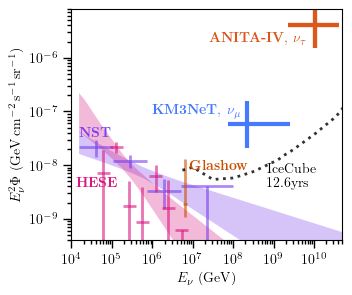

In [ ]:
# Create figure with log scale
fig, ax = plt.subplots(figsize=(lat_linewidth, lat_linewidth/1.2))
ax.set_xscale('log')
ax.set_yscale('log')
plotdata(ax,NSTdata,NST_ylims,NST_xlims,"NST", '#793EED')
plotdata(ax,HESEdata,HESE_ylims,HESE_xlims,"HESE",  '#DA1781')
plotdata(ax,Glashowdata,Glashow_ylims,Glashow_xlims,"Glashow",'#CC4E00')
plotdata(ax,K3data,K3_ylims,K3_xlims,"K3",'#4579FF', alpha = 1, elinewidth=3)

eefit = np.geomspace(1.5e4,5e10,50)*muns.GeV
ax.fill_between(eefit/muns.GeV,NST_interp(eefit)[0],NST_interp(eefit)[1], color = '#793EED', alpha = 0.3, lw = 0)
ax.fill_between(eefit/muns.GeV,HESE_interp(eefit)[0],HESE_interp(eefit)[1], color = '#DA1781', alpha = 0.3, lw = 0)

# print(anita_flux(10.4*muns.EeV),anita_flux(10.4*muns.EeV))

anita_energies = np.array([12.5,5.2,8.8,15.1])*muns.EeV
anita_euperr = np.array([29.9,11.0,19.5,27.3])*muns.EeV
anita_eloerr = np.array([7.4,2.9,4.9,7.6])*muns.EeV
anita_fluxes = anita_flux(anita_energies)
anita_loflux = anita_flux(anita_energies+anita_euperr)
anita_upflux = anita_flux(anita_energies-anita_eloerr)

ecent = np.mean(anita_energies)
fcent = anita_flux(ecent)*4
emin, emax = np.min(anita_energies-anita_eloerr), np.max(anita_energies+anita_euperr)
# ax.axvline(2.3e9)
fmin, fmax = 4*np.min(anita_loflux), np.max(anita_upflux)*4
ax.errorbar([ecent/muns.GeV,ecent/muns.GeV],
            [fcent,fcent],
            xerr = [((ecent-emin)/muns.GeV,(ecent-emin)/muns.GeV), ((emax-ecent)/muns.GeV,(emax-ecent)/muns.GeV)],
            yerr = [((fcent-fmin),(fcent-fmin)), (fmax-fcent,fmax-fcent)],
            elinewidth= 3, color = '#DB571A')

xmin = np.mean(anita_energies)-np.min(anita_energies-anita_eloerr)
xmax = -np.mean(anita_energies)+np.min(anita_energies+anita_euperr)
ymin = anita_flux(np.mean(anita_energies)-xmin)-anita_flux(np.mean(anita_energies))
ymax = anita_flux(np.mean(anita_energies))-anita_flux(np.mean(anita_energies)+xmax)
ymin = np.min(anita_flux(anita_energies+anita_euperr))
ymax = np.min(anita_flux(anita_energies-anita_eloerr))
print(ymin, ymax)

ax.text(2.5e7,2e-6,r"\textbf{ANITA-IV}, $\nu_\tau$", color = '#DB571A')
ax.text(1.5e4,3.5e-8,r"\textbf{NST}", color = '#793EED')
ax.text(1.3e4,4e-9,r"\textbf{HESE}", color = '#DA1781')
ax.text(8e6,8e-9,r"\textbf{Glashow}", color = '#CC4E00')
ax.text(1e6,9e-8,r"\textbf{KM3NeT}, $\nu_\mu$", color = '#4579FF')
ax.text(7e8,4e-9,"IceCube\n12.6yrs", color = 'k')

ax.plot(IC_bounds[:,0],IC_bounds[:,1], color = 'k', alpha = 0.8, ls = ':')
# Add labels and title
ax.set_xlabel(r'$E_\nu\ (\mathrm{GeV})$')
ax.set_ylabel(r'$E_\nu^2\Phi\ (\mathrm{GeV}\, \mathrm{cm}^{-2}\, \mathrm{s}^{-1}\, \mathrm{sr}^{-1})$')
ax.set_xlim(1e4,5e10)
ax.set_ylim(4e-10,8e-6)
ax.set_xticks(np.geomspace(1e4,1e10,7))

nticks = 7
maj_loc = ticker.LogLocator(numticks=nticks)
min_loc = ticker.LogLocator(subs='all', numticks=nticks)
ax.xaxis.set_major_locator(maj_loc)
ax.xaxis.set_minor_locator(min_loc)

ax.xaxis.set_tick_params(which='minor')

fig.show()
# fig.savefig(plotdirK+'FluxesComparison_SM.svg')

## Azimuthal plot

I would compare absorption without no absorption, or two different cross-sections.

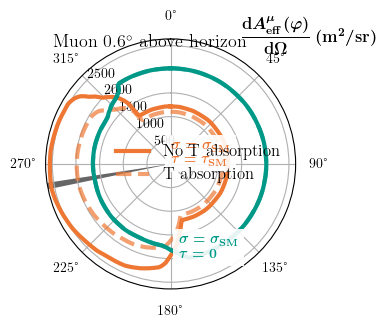

In [ ]:
varphi = np.linspace(0,2*np.pi,300)
pars.is_T_absorbed = False
pp = np.array([K3.EffectiveAreaMuon(v,K3.Event_Elev,2.35e-32*2/3,5e-6) for v in varphi])

pars.is_T_absorbed = True
# totaeff = K3.TotalEffectiveAreaMuon(3.33e-32/2,2e-4)
pp2 = np.array([K3.EffectiveAreaMuon(v,K3.Event_Elev,2.35e-32*2/3,5e-6) for v in varphi])

pars.is_T_absorbed = False
pp3 = np.array([K3.EffectiveAreaMuon(v,K3.Event_Elev,2.35e-32,1e-3) for v in varphi])

pars.is_T_absorbed = True
pp4 = np.array([K3.EffectiveAreaMuon(v,K3.Event_Elev,2.35e-32,1e-3) for v in varphi])

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'},figsize=(lat_linewidth*1.1, lat_linewidth*1.1))

ax.plot(varphi,pp3/muns.m**2, lw = 3, color = vibrant[1], ls = '-', alpha = 1, label = 'No T absorption')
ax.plot(varphi,pp4/muns.m**2, lw = 3, color = vibrant[1], ls = '--', alpha = 0.7,  label = 'T absorption')
ax.plot(varphi,pp/muns.m**2, lw = 3, color = vibrant[0], ls = '-', alpha = 1)
ax.plot(varphi,pp2/muns.m**2, lw = 3, color = vibrant[0], ls = '--', alpha = 0.7)

ax.set_rlabel_position(315)
ax.set_theta_zero_location("N")
ax.set_theta_direction('clockwise')

text = ax.text(175/180*np.pi,2000,r"$\boldsymbol{\sigma = \sigma_{\mathrm{SM}}}$"+"\n"+r"$\boldsymbol{\tau = 0}$", color = vibrant[0])
text.set_bbox(dict(facecolor='w',alpha = 0.9, lw = 0))
text2 = ax.text(330/180*np.pi,0.264,r"$\boldsymbol{\sigma = \sigma_{\mathrm{SM}}}$"+"\n"+r"$\boldsymbol{\tau = \tau_{\mathrm{SM}}}$", color = vibrant[1],backgroundcolor = 'w')
text2.set_bbox(dict(facecolor='w',alpha = 0.9, lw = 0))
ax.text(30/180*np.pi,3000,r"$\boldsymbol{\dfrac{\mathrm{d}A_{\mathrm{eff}}^\mu(\varphi)}{\mathrm{d}\Omega}\, (\mathrm{m}^2/\mathrm{sr})}$", fontsize = 12)
ax.text(315/180*np.pi,3500,r"Muon $0.6^\circ$ above horizon", fontsize = 13)
ax.axvspan(K3.Event_Azim-K3.Event_Err,K3.Event_Azim+K3.Event_Err, lw = 0, color = 'k', alpha = 0.6, zorder = 1)

ax.grid(True)
ax.legend()
fig.show()
# fig.savefig(plotdirK+"azimuthal_plot_SM.svg")

## $(\varphi,\theta)$ plot

Probably without absorption.

In [ ]:
def plot_cardinal_points(ax, color = 'k'):
    ax.text(15,4.2,"N", color = color, fontsize = 9,horizontalalignment='center')
    ax.text(90,4.2,"E", color = color, fontsize = 9,horizontalalignment='center')
    ax.text(180,4.2,"S", color = color, fontsize = 9,horizontalalignment='center')
    ax.text(270,4.2,"W", color = color, fontsize = 9,horizontalalignment='center')
    ax.axvline(0, ls = '--', color = color, alpha = 0.05, lw = 1)
    ax.axvline(90, ls = '--', color = color, alpha = 0.05, lw = 1)
    ax.axvline(180, ls = '--', color = color, alpha = 0.05, lw = 1)
    ax.axvline(270, ls = '--', color = color, alpha = 0.05, lw =1)
    ax.axhline(0, ls = '--', color = color, alpha = 0.05, lw = 1)
    return None

def plot_event(ax, color = 'w'):
    ax.errorbar(K3.Event_Azim/muns.degs,K3.Event_Elev/muns.degs,K3.Event_Err/muns.degs,K3.Event_Err/muns.degs,
               marker = 'o',markersize = 4, color = color)    

258022.10826009975


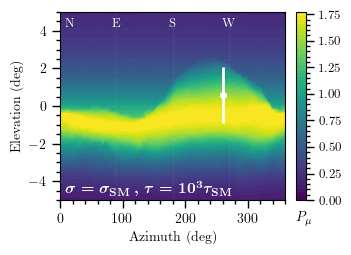

In [ ]:
i_pars =  'bigt'# 'SMmuon'#, 'SMtau', 'BF', 'lows', 'bigt'
dict_pars = {'SMmuon':(2.35e-32*muns.cm**2, 5e-6*muns.s),
             'SMtau': (2.35e-32*muns.cm**2, 1.67e-4*muns.s),
             'BF':    (2.1e-32*muns.cm**2, 4e-4*muns.s),
             'lows':  (2.35e-34*muns.cm**2, 4e-4*muns.s),
             'bigt':  (2.35e-32*muns.cm**2, 1.67e-1*muns.s)}
xs, lt = dict_pars[i_pars]

# We compute the arrays which we will plot
azz = np.arange(0,361,2)*muns.degs # azimuthal angles to plot
thh = np.linspace(-5,5,60)*muns.degs # elevation angles to plot
azz_mesh, thh_mesh = np.meshgrid(azz,thh, indexing='ij')

effect_area200  = np.zeros((azz.shape[0], thh.shape[0]))
rock_lengths  = np.zeros((azz.shape[0], thh.shape[0]))
water_lengths  = np.zeros((azz.shape[0], thh.shape[0]))

for i,az in enumerate(azz):
    for j,th in enumerate(thh):
        effect_area200[i,j] = K3.EffectiveAreaMuonDirEnergy(az,th,xs,lt)
        water_lengths[i,j], rock_lengths[i,j] = K3.length(az,th, total_output= False)

begin = time.time()
aeffmu_tot = K3.TotalEffectiveAreaMuon(xs,lt,eps = 1e-1)

maxaeff = {'bigt': 258022.10826009975,
           'SMmuon': 47299025.104004405,
           'SMtau': 63040516.209890015,
           'BF': 48461857.22203513,
           'lows': 1323777.8067156833}
print(np.max(effect_area200))

fig_aeff, ax200 = plt.subplots(figsize=(lat_linewidth,lat_linewidth/1.4))

for ax in [ax200]:
    plot_cardinal_points(ax,{'SMmuon': 'k', 'SMtau': 'w', 'BF': 'w','lows':'w', 'bigt': 'w'}[i_pars])
    plot_event(ax)
    ax.set_ylabel(r'Elevation (deg)')
    ax.set_xlabel(r'Azimuth (deg)')
    ax.tick_params(axis='both', which='major')

# print(np.max(effect_area200/aeffmu_tot),np.ceil(np.max(effect_area200/aeffmu_tot)),np.ceil(np.max(effect_area200/aeffmu_tot)*100)/100)
levels = np.linspace(0,np.max(effect_area200/aeffmu_tot),50)
# levels = {'SMmuon':np.linspace(0,np.ceil(np.max(effect_area200/aeffmu_tot)*100)/100,50),
#           'SMtau': np.linspace(0,np.ceil(np.max(effect_area200/aeffmu_tot)*100)/100,50),
#           'BF':    np.arange(0,np.ceil(np.max(effect_area200/aeffmu_tot)),0.)}
contour = ax200.contourf(azz_mesh/muns.degs, thh_mesh/muns.degs, effect_area200/aeffmu_tot, levels=levels, cmap='viridis')
cbar = fig_aeff.colorbar(contour,ax = ax200)

# cbarlabel = r'$\mathcal{A}_\mu(\varphi,\theta)/\int \mathrm{d}\varphi\, \mathrm{d}\theta \mathcal{A}_\mu(\varphi,\theta)$'
# cbarlabel = r'$\mathcal{A}_\mu(\Omega)/\int \mathrm{d}\Omega\, \mathcal{A}_\mu(\Omega)$'
cbarlabel = 'Probability density'
# cbar.set_label(cbarlabel)
cbar.ax.tick_params(labelsize=9)
# cbar.ax.set_yticks(np.linspace(0,np.ceil(np.max(effect_area200/aeffmu_tot)*100)/100,6))
from matplotlib.ticker import MultipleLocator
if i_pars in ['SMtau','BF','bigt']:
    cbar.ax.yaxis.set_major_locator(MultipleLocator(0.25))
    cbar.ax.yaxis.set_minor_locator(MultipleLocator(0.05))
elif i_pars in ['SMmuon','lows']: 
    cbar.ax.yaxis.set_major_locator(MultipleLocator(0.05))
    cbar.ax.yaxis.set_minor_locator(MultipleLocator(0.01))

labels = {'SMmuon':r"$\boldsymbol{\sigma = \sigma_{\mathrm{SM}}\, ,\, \tau = 0}$",
          'SMtau': r"$\boldsymbol{\sigma = \sigma_{\mathrm{SM}}\, ,\, \tau = \tau_{\mathrm{SM}}}$",
          'BF':    r"$\boldsymbol{\sigma = \sigma_{\mathrm{BF}}\, ,\, \tau = \tau_{\mathrm{BF}}}$",
          'lows':    r"$\boldsymbol{\sigma = 0.01\sigma_{\mathrm{SM}}\, ,\, \tau = \tau_{\mathrm{SM}}}$",
          'bigt':    r"$\boldsymbol{\sigma = \sigma_{\mathrm{SM}}\, ,\, \tau = 10^3\tau_{\mathrm{SM}}}$"}
colors = {'SMmuon': 'white','SMtau': 'white','BF': 'white','lows': 'k', 'bigt': 'w'}
ax200.text(7,-4.6,
             labels[i_pars],
             color = colors[i_pars], fontsize = 11)

fig_aeff.text(1.05, -0.1, r"$P_\mu$", va='center', ha='left', transform=ax.transAxes)
ax200.set_ylim(-5,5)
fig_aeff.show()
# fig_aeff.savefig(plotdirK+"MuonEffectiveArea_"+i_pars+".svg")

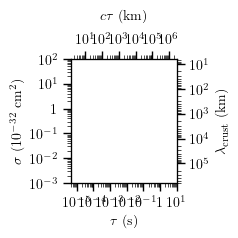

In [ ]:
datxs = np.logspace(-30,-35,100)
datlt = np.geomspace(5e-6,10,100)
xxs, llt = np.meshgrid(datxs,datlt, indexing= 'ij')
minxs, maxxs = 1e-35, 1e-30
minlt, maxlt = 1e-6, 1e1
eK3 = K3.Event_Energy

fig,ax = plt.subplots(figsize=(lat_linewidth/1.5,lat_linewidth/1.5))

plvars.tick_size = 10
plvars.font_size = 10
plvars.create_xslt_axis(ax,minxs,maxxs,minlt,maxlt)
plvars.create_mfp_axis(ax,minxs,maxxs)
plvars.create_decaylength_axis(ax,minlt,maxlt)

# fig.savefig(plotdirK+'ParameterSpace.svg')

Now the same, but trying to keep the same normalization for all plots

17714.994633706086


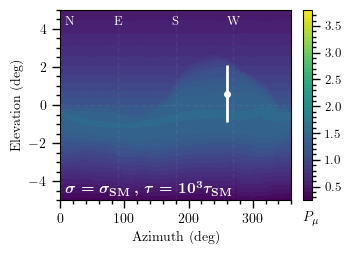

In [ ]:
i_pars =  'bigt'# 'SMmuon'#, 'SMtau', 'BF', 'lows', 'bigt'

dict_pars = {'SMmuon':(2.35e-32*muns.cm**2, 5e-6*muns.s),
             'SMtau': (2.35e-32*muns.cm**2, 1.67e-4*muns.s),
             'BF':    (2.1e-32*muns.cm**2, 4e-4*muns.s),
             'lows':  (2.35e-34*muns.cm**2, 4e-4*muns.s),
             'bigt':  (2.35e-32*muns.cm**2, 1.67e-1*muns.s)}
xs, lt = dict_pars[i_pars]

# pars.is_T_absorbed = False

# We compute the arrays which we will plot
azz = np.arange(0,361,2)*muns.degs # azimuthal angles to plot
thh = np.linspace(-5,5,60)*muns.degs # elevation angles to plot
azz_mesh, thh_mesh = np.meshgrid(azz,thh, indexing='ij')

effect_area200  = np.zeros((azz.shape[0], thh.shape[0]))
rock_lengths  = np.zeros((azz.shape[0], thh.shape[0]))
water_lengths  = np.zeros((azz.shape[0], thh.shape[0]))

for i,az in enumerate(azz):
    for j,th in enumerate(thh):
        effect_area200[i,j] = K3.EffectiveAreaMuonDirEnergy(az,th,xs,lt)
        water_lengths[i,j], rock_lengths[i,j] = K3.length(az,th, total_output= False)

begin = time.time()
aeffmu_tot = K3.TotalEffectiveAreaMuon(xs,lt,eps = 1e-1)

maxaeff = {'bigt': 258022.10826009975,
           'SMmuon': 47299025.104004405,
           'SMtau': 63040516.209890015,
           'BF': 48461857.22203513,
           'lows': 1323777.8067156833}
minaeff = {'bigt': 17714.994633706086,
           'SMmuon': 589189.4981175517,
           'SMtau': 758524.240537346,
           'BF': 1120216.6226949801,
           'lows': 116064.01013327831}
print(np.min(effect_area200))

# print(lat_textwidth,lat_linewidth)

fig_aeff, ax200 = plt.subplots(figsize=(lat_linewidth,lat_linewidth/1.4))

for ax in [ax200]:
    plot_cardinal_points(ax,{'SMmuon': 'k', 'SMtau': 'w', 'BF': 'w','lows':'w', 'bigt': 'w'}[i_pars])
    plot_event(ax)
    ax.set_ylabel(r'Elevation (deg)')
    ax.set_xlabel(r'Azimuth (deg)')
    ax.tick_params(axis='both', which='major')

# print(np.max(effect_area200/aeffmu_tot),np.ceil(np.max(effect_area200/aeffmu_tot)),np.ceil(np.max(effect_area200/aeffmu_tot)*100)/100)
levels = np.linspace(0,np.max(effect_area200/aeffmu_tot),50)
levels = np.linspace(0,63040516.209890015/muns.m**2,50)
levels = np.linspace(np.log10(17714.994633706086/muns.m**2),np.log10(63040516.209890015/muns.m**2),50)
# levels = {'SMmuon':np.linspace(0,np.ceil(np.max(effect_area200/aeffmu_tot)*100)/100,50),
#           'SMtau': np.linspace(0,np.ceil(np.max(effect_area200/aeffmu_tot)*100)/100,50),
#           'BF':    np.arange(0,np.ceil(np.max(effect_area200/aeffmu_tot)),0.)}
contour = ax200.contourf(azz_mesh/muns.degs, thh_mesh/muns.degs, np.log10(effect_area200/muns.m**2), levels=levels, cmap='viridis')
cbar = fig_aeff.colorbar(contour,ax = ax200)
# cbarlabel = r'$\mathcal{A}_\mu(\varphi,\theta)/\int \mathrm{d}\varphi\, \mathrm{d}\theta \mathcal{A}_\mu(\varphi,\theta)$'
# cbarlabel = r'$\mathcal{A}_\mu(\Omega)/\int \mathrm{d}\Omega\, \mathcal{A}_\mu(\Omega)$'
cbarlabel = 'Aeff'
# cbar.set_label(cbarlabel)
cbar.ax.tick_params(labelsize=9)
# cbar.ax.set_yticks(np.linspace(0,np.ceil(np.max(effect_area200/aeffmu_tot)*100)/100,6))
from matplotlib.ticker import MultipleLocator
cbar.ax.yaxis.set_major_locator(MultipleLocator(0.5))
cbar.ax.yaxis.set_minor_locator(MultipleLocator(0.1))
# if i_pars in ['SMtau','BF','bigt']:
#     cbar.ax.yaxis.set_major_locator(MultipleLocator(0.25))
#     cbar.ax.yaxis.set_minor_locator(MultipleLocator(0.05))
# elif i_pars in ['SMmuon','lows']: 
#     cbar.ax.yaxis.set_major_locator(MultipleLocator(0.05))
#     cbar.ax.yaxis.set_minor_locator(MultipleLocator(0.01))

# labels = {'SMmuon':r"$\sigma = \sigma_{\mathrm{SM}}\, ,\, \tau = 0$",
#           'SMtau': r"$\sigma = \sigma_{\mathrm{SM}}\, ,\, \tau = \tau_{\mathrm{SM}}$",
#           'BF':    r"$\sigma = \sigma_{\mathrm{BF}}\, ,\, \tau = \tau_{\mathrm{BF}}$",
#           'lows':  r"$\sigma = 0.01\sigma_{\mathrm{BF}}\, ,\, \tau = \tau_{\mathrm{BF}}$"}
labels = {'SMmuon':r"$\boldsymbol{\sigma = \sigma_{\mathrm{SM}}\, ,\, \tau = 0}$",
          'SMtau': r"$\boldsymbol{\sigma = \sigma_{\mathrm{SM}}\, ,\, \tau = \tau_{\mathrm{SM}}}$",
          'BF':    r"$\boldsymbol{\sigma = \sigma_{\mathrm{BF}}\, ,\, \tau = \tau_{\mathrm{BF}}}$",
          'lows':    r"$\boldsymbol{\sigma = 0.01\sigma_{\mathrm{SM}}\, ,\, \tau = \tau_{\mathrm{SM}}}$",
          'bigt':    r"$\boldsymbol{\sigma = \sigma_{\mathrm{SM}}\, ,\, \tau = 10^3\tau_{\mathrm{SM}}}$"}
colors = {'SMmuon': 'white','SMtau': 'white','BF': 'white','lows': 'k', 'bigt': 'w'}
ax200.text(7,-4.6,
             labels[i_pars],
             color = colors[i_pars], fontsize = 11)

# ax200.text(0.8,0.2,r"$P_\mu$",transform=plt.gcf().transFigure)
# fig_aeff.suptitle(labels[i_pars])
fig_aeff.text(1.05, -0.1, r"$P_\mu$", va='center', ha='left', transform=ax.transAxes)
ax200.set_ylim(-5,5)
fig_aeff.show()
# fig_aeff.savefig(plotdirK+"MuonEffectiveArea_"+i_pars+"_samenorm.svg")
fig_aeff.show()

## Fit KM3NeT-only

Plot with absorption and without absorption.

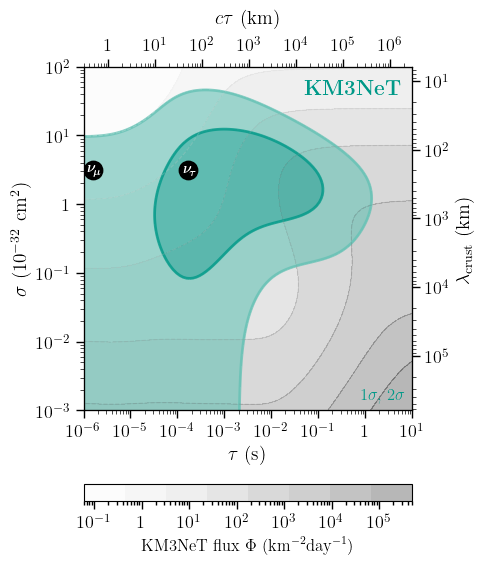

In [ ]:
minxs, maxxs = 1e-35, 1e-30
minlt, maxlt = 1e-6, 1e1
datxs = np.geomspace(minxs,maxxs,100)
datlt = np.geomspace(minlt,maxlt,100)
xxs, llt = np.meshgrid(datxs,datlt, indexing= 'ij')
eK3 = K3.Event_Energy

# fig,ax = plt.subplots(figsize=(15*cmp,10*cmp))
fig,ax = plt.subplots(figsize=(12*cmp,14*cmp))

# first we plot the flux in the background
flux = A3.BestFitDiffuseFluxKM3NeT(xxs,llt,1.0)*muns.km**2*muns.day
fluxmin,   fluxmax   = np.min(flux), np.max(flux)
ifluxmin, ifluxmax = np.log10(plvars.floor_to_int(fluxmin)),  np.log10(plvars.ceil_to_int(fluxmax))

num_of_levels = 8
levels = np.linspace(ifluxmin,ifluxmax,num_of_levels+1)
conts_lines = ax.contour(np.log10(datlt),np.log10(datxs*1e32),np.log10(flux), 
                        levels = levels, 
                        cmap = 'Greys',
                        alpha = 0.25,
                        linestyles = '--',
                        linewidths = 0.8)
conts = ax.contourf(np.log10(datlt),np.log10(datxs*1e32),np.log10(flux), 
                        levels = levels, 
                        cmap = 'Greys', 
                        alpha = 0.3)

# now we plot the test statistic
tsk3 = A3.DiffuseTestStatisticK3(xxs,llt,1.0,flux/muns.km**2/muns.day)
min_index = np.where(tsk3 == np.min(tsk3))
bestfit = tsk3[min_index]
xsbf = datxs[min_index[0]][0]
ltbf = datlt[min_index[1]][0]
phbf = A3.BestFitDiffuseFluxKM3NeT(xsbf,ltbf,1.0)*muns.km**2*muns.day
# brbf = A3.BestFitBranchingRatioNoPhi(xsbf,ltbf)
dts = tsk3-bestfit

colors = ['#005FA3','#0A99FF']
colors = ['#8BE4DE','#ADEBE7']
colors = ['#009988','#66C2B5']
ax.contourf(np.log10(datlt),np.log10(datxs*1e32),dts,
                    zorder = 1, levels = [0,plvars.sigma1,plvars.sigma2],#, plvars.sigma3], 
                    colors = [colors[0],colors[1]],#, plvars.color3],
                    alpha = 0.6)
ax.contour(np.log10(datlt),np.log10(datxs*1e32),dts,
                    zorder = 1, levels = [plvars.sigma1,plvars.sigma2],#, plvars.sigma3], 
                    colors = [colors[0],colors[1]],linewidths = 2,#, plvars.color3],
                    alpha = 0.8)

# plvars.set_colorbar(fig,ax,conts,ifluxmin, ifluxmax, r'KM3NeT flux $\Phi \ (\textrm{km}^{-2}\textrm{day}^{-1})$')
cbar = fig.colorbar(conts, ax = ax, location = 'bottom', orientation = 'horizontal')#location = 'right')#, orientation = 'horizontal') #pad = 0.16, 
cbar.ax.set_xlabel(r'KM3NeT flux $\Phi \ (\textrm{km}^{-2}\textrm{day}^{-1})$', fontsize = 12)
cbar.ax.tick_params(axis='both', which='major', labelsize=12)
plvars.set_colorbar_ticks(cbar,ifluxmin,ifluxmax, where = 'vertical')

ax.text(-1.3,1.6,r"\textbf{KM3NeT}", fontsize = 15, color = '#009988')

plvars.create_mfp_axis(ax,minxs,maxxs)
plvars.create_decaylength_axis(ax,minlt,maxlt)
plvars.create_xslt_axis(ax,minxs,maxxs,minlt,maxlt)
plot_SMlike(ax)

ax.text(-0.1,-2.85,r"$1\sigma,\, 2\sigma$", fontsize = 12, color = vibrant[0])

fig.show()
# fig.savefig(plotdirK+'TestStatisticKM3NeT_TAbsorption.pdf')

## K3+ANITA

[-23.06427681]


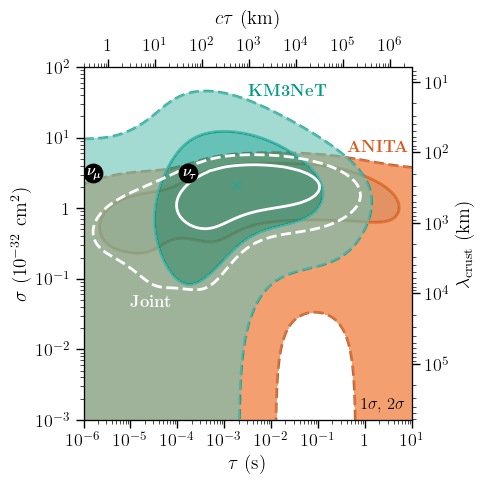

In [ ]:
fig,ax = plt.subplots(figsize=(12*cmp,12*cmp))

minxs, maxxs = 1e-35, 1e-30
minlt, maxlt = 1e-6, 1e1
datxs = np.geomspace(minxs,maxxs,100)
datlt = np.geomspace(minlt,maxlt,100)
xxs, llt = np.meshgrid(datxs,datlt, indexing= 'ij')
ax.set_xlim(np.log10(minlt),np.log10(maxlt))
ax.set_ylim(np.log10(minxs)+32,np.log10(maxxs)+32)


# now we plot the test statistic, this is the joint
tsan = AN.DiffuseTotalTestStatisticInterp(xxs,llt,0.0)
min_index = np.where(tsan == np.min(tsan))
bestfit = tsan[min_index]
xsbf = datxs[min_index[0]][0]
ltbf = datlt[min_index[1]][0]
dtsa = tsan-bestfit

ax.contour(np.log10(datlt),np.log10(datxs*1e32),dtsa,
                    zorder = 1, levels = [0,plvars.sigma1,plvars.sigma2],#, plvars.sigma3], 
                    colors = "#9C4016", linestyles = ['--','-'], linewidths = 2, alpha = 0.8)
ax.contourf(np.log10(datlt),np.log10(datxs*1e32),dtsa,
                    zorder = 1, levels = [0,plvars.sigma1,plvars.sigma2],#, plvars.sigma3], 
                    colors = ["#D76421",'#EE7733'] ,#, plvars.color3],
                    alpha = 0.7)

# now we plot the test statistic, this is the joint
tsk3 = K3.DiffuseEventTestStatistic(xxs,llt,1.0)
min_index = np.where(tsk3 == np.min(tsk3))
bestfit = tsk3[min_index]
xsbf = datxs[min_index[0]][0]
ltbf = datlt[min_index[1]][0]
dtsk3 = tsk3-bestfit

ax.contour(np.log10(datlt),np.log10(datxs*1e32),dtsk3,
                    zorder = 1, levels = [0,plvars.sigma1,plvars.sigma2],#, plvars.sigma3], 
                    colors = vibrant[0], linestyles = ['--','-'], linewidths = 2, alpha = 0.8)
ax.contourf(np.log10(datlt),np.log10(datxs*1e32),dtsk3,
                    zorder = 1, levels = [0,plvars.sigma1,plvars.sigma2],#, plvars.sigma3], 
                    colors = ['#009988','#66C2B5'] ,#, plvars.color3],
                    alpha = 0.6)

# now we plot the test statistic, this is the joint
tsa3 = A3.DiffuseTestStatisticBestFitA3(xxs,llt)
min_index = np.where(tsa3 == np.min(tsa3))
bestfit = tsa3[min_index]
print(bestfit)
xsbf = datxs[min_index[0]][0]
ltbf = datlt[min_index[1]][0]

dtsa3 = tsa3-bestfit

ax.contour(np.log10(datlt),np.log10(datxs*1e32),dtsa3,
                    zorder = 1, levels = [plvars.sigma1,plvars.sigma2],#, plvars.sigma3], 
                    colors = ['w'] , linestyles = ['-','--'],#, plvars.color3],
                    alpha = 1.0)

sigma_color = '#DB571A'
ax.text(-2.5,1.6,r"\textbf{KM3NeT}", fontsize = 12, color = '#009988')
ax.text(-5,-1.4,r"\textbf{Joint}", fontsize = 12, color = 'w')
ax.text(-0.38,0.8,r"\textbf{ANITA}", fontsize = 12, color = '#DB571A')
ax.scatter(np.log10(ltbf),np.log10(xsbf)+32, marker = 'x', c = '#28A49C', lw = 1, label = 'SM', zorder = 121)

plot_SMlike(ax)
ax.text(-0.1,-2.85,r"$1\sigma,\, 2\sigma$", fontsize = 12)
plvars.create_mfp_axis(ax,minxs,maxxs)
plvars.create_decaylength_axis(ax,minlt,maxlt)
plvars.create_xslt_axis(ax,minxs,maxxs,minlt,maxlt)
# fig.savefig(plotdirK+'TestStatistic_ANITAK3_TAbsorption.pdf')

fig.show()

# Fluxes and number of events

The data plotted here is taken from the notebook AllFits.ipynb

/tmp/ipykernel_488677/1232362897.py:204: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.savefig(plotdirK+"BestFitFluxesEvents.pdf")
/home/tbertolez/Dropbox/Doctorat/Neutrinos/UltraHighEnergy/BSMatUHEexps/venv_UHE/lib/python3.9/site-packages/IPython/core/events.py:82: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  func(*args, **kwargs)
/home/tbertolez/Dropbox/Doctorat/Neutrinos/UltraHighEnergy/BSMatUHEexps/venv_UHE/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


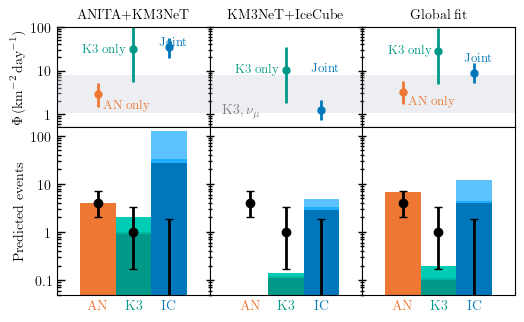

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as ticker

def auger_cosmic_ray_flux(i = 1):
    dat = np.loadtxt(homedir+'PlotData/AugerFlux.dat', delimiter= ",")
    Ec = dat[:,0]*muns.eV
    E3J = dat[:,i]*muns.eV**2/muns.year*4*np.pi/muns.km**2
    J = E3J/Ec**3
    Jtot = np.trapz(J,Ec)
    return Jtot*muns.km**2*muns.day

# Figure setup
fig = plt.figure(figsize=(lat_textwidth, lat_textwidth/1.7))

# Create grid with row height ratio 3:4 and no spacing
grid = GridSpec(2, 3, hspace=0, wspace=0, height_ratios=[3, 5])

# Create axes
axes = [[fig.add_subplot(grid[i, j]) for j in range(3)] for i in range(2)]

# Share y-axes within rows
for j in range(1, 3):
    axes[0][j].sharey(axes[0][0])
    axes[1][j].sharey(axes[1][0])

# Set column titles
col_titles = ['ANITA+KM3NeT', 'KM3NeT+IceCube', 'Global fit']
subtitle = {'ANITA+KM3NeT': '\n'+r"$\sigma = 2.1\times 10^{-32}\, \mathrm{cm}^2$", 
            'KM3NeT+IceCube': '\n'+r"$\sigma = 0.7\times 10^{-32}\, \mathrm{cm}^2$", 
            'Global fit': '\n'+r"$\sigma = 0.5\times 10^{-32}\, \mathrm{cm}^2$"}
for ax, title in zip(axes[0], col_titles):
    ax.set_title(title, fontsize = 10)
    # ax.set_title(title+subtitle[title], fontsize = 10)

from scipy.stats import gamma
alpha = 1-0.6827
an_low, an_up = gamma.ppf(alpha/2, 4, scale = 1), gamma.ppf(1.-alpha/2, 4+1, scale = 1)
k3_low, k3_up = gamma.ppf(alpha/2, 1, scale = 1), gamma.ppf(1.-alpha/2, 1+1, scale = 1)
tot_low, tot_up = gamma.ppf(alpha/2, 5, scale = 1), gamma.ppf(1.-alpha/2, 5+1, scale = 1)
ic_up =  gamma.ppf(1.-alpha/2, 0+1, scale = 1)

# Configure axes
for i, row in enumerate(axes):
    for j, ax in enumerate(row):
        # X-axis setup (categorical, no ticks/labels)
        ax.set_xticks([])
        ax.set_xticklabels([])
        
        # Y-axis setup (logarithmic with plain number formatting)
        ax.set_yscale('log')
        ax.set_ylim([0.5,0.05][i], [100,150][i])
        # ax.set_xlim(0,2)
        ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%g'))
        ax.minorticks_on()
        
        # Tick parameters - different for leftmost vs shared axes
        if j == 0:  # Leftmost axes
            ax.tick_params(axis='y', which='both', direction='in', labelsize=10)
        else:  # Shared axes
            ax.tick_params(axis='y', which='both', direction='inout', labelleft=False)
        
        # Prepare for 3 categorical bars
        ax.set_xlim(-0.5, 2.5)

# Set y-axis labels
axes[0][0].set_ylabel('$\Phi\, (\mathrm{km}^{-2}\, \mathrm{day}^{-1})$')
axes[1][0].set_ylabel('Predicted events')
axes[0][1].text(-0.25,1,r"K3,$\,\nu_\mu$", color = 'gray')

# UPPER ROW DATA
# Data for upper row (flux values)
data_upper = {
    "ANITA+KM3NeT": {
        "AN only": (2.868, 2.868/4*an_low, 2.868/4.*an_up),
        "K3 only": (31.38, 31.38*k3_low, 31.38*k3_up),
        "Joint": (34.3, 34.3/5.*tot_low, 34.3/5.*tot_up)
    },
    "KM3NeT+IceCube": {
        "AN only": (1000, 800, 2000), # away from the plot
        "K3 only": (10.5, 10.5*k3_low, 10.5*k3_up),
        "Joint": (1.27, 1.27/5.*tot_low, 1.27/5.*tot_up)
    },
    "Global fit": {
        "AN only": (3.303, 3.303/4.*an_low, 3.303/4.*an_up),
        "K3 only": (28.45, 28.45*k3_low, 28.45*k3_up),
        "Joint": (9.04, 9.04/5.*tot_low, 9.04/5.*tot_up)
    }
}

# Colors and styling
colors = [vibrant[1],vibrant[0],vibrant[2]]  # ANITA, K3, Joint
# colors = ["#DB571A", "#4579FF", "#8BE4DE"]  # ANITA, K3, Joint
text_offsets = [(0.4, -1.3), (-1, -0.15), (-0.5, 10)]

# needs to run the third
k3flux = K3data[0,1]/K3data[0,0]*muns.km**2*muns.day*4*np.pi
alphas = [0.5,0.5,1]
alphas = [1,1,1]
# Plot upper row data points
for j, title in enumerate(col_titles):
    ax = axes[0][j]
    sample_data = data_upper[title]
    # ax.axhline(k3flux, ls = '--', color = 'gray', alpha = 0.6)
    ax.axhspan(K3_ylims[0,0]/K3data[0,0]*muns.km**2*muns.day*4*np.pi,
               K3_ylims[0,1]/K3data[0,0]*muns.km**2*muns.day*4*np.pi,
               color = '#D0D6DC', alpha = 0.4, zorder = 2, ec = '#D0D6DC', lw = 0)

    # ax.axhspan(np.log10(auger_cosmic_ray_flux(i=2)),np.log10(auger_cosmic_ray_flux(i=3)), 
    #                   color = '#D0D6DC', alpha = 0.6, zorder = 2, ec = '#D0D6DC', lw = 1)

    for i, (label, color) in enumerate(zip(["AN only", "K3 only", "Joint"], colors)):
        central, lower, upper = sample_data[label]
        yerr = [[central - lower], [upper - central]]
        
        ax.errorbar(x=0.3+0.7*i, y=central, yerr=yerr, 
                   fmt='o', color=color, markersize=5, linewidth = 0,
                   elinewidth=2, capsize=0, alpha = alphas[i])
        
        dx, dy = text_offsets[i]
        if j != 1 or i != 0:
            ax.text(x=i + dx, y=central + dy, s=label,
                    color=color, fontsize=9, va='center')

# LOWER ROW DATA
# Data for stacked histograms
data_lower_components = {
    "ANITA+KM3NeT": {
        "ANITA": [4.02],
        "KM3NeT": [0.90,0.10,1.02],  # Sum = 32
        "IceCube": [27.64,5.76,94.94]    # Sum = 28
    },
    "KM3NeT+IceCube": {
        "ANITA": [0],
        "KM3NeT": [0.11,0.01,0.02],
        "IceCube": [2.83,0.44,1.47]
    },
    "Global fit": {
        "ANITA": [6.77],
        "KM3NeT": [0.10,0.01,0.09],
        "IceCube": [3.97,0.49,7.68]
    }
}

# Colors for subcomponents
# km3net_colors = ["#3A66CC", "#4579FF", "#6B91FF"]  # Dark to light blue
km3net_colors = [vibrant[0], "#00B8A2", "#00CCB4"]  # Dark to light teal
icecube_colors = [vibrant[2], "#1FADFF", "#5CC3FF"]  # Dark to light blue

# Plot lower row stacked histograms
for j, title in enumerate(col_titles):
    ax = axes[1][j]
    components = data_lower_components[title]
    x_pos = [0.3, 1, 1.7]
    
    # ANITA (single bar)
    ax.bar(x_pos[0], components["ANITA"][0],
          width=0.7, color=colors[0], linewidth=0)
    
    # KM3NeT (stacked with color gradient)
    bottom = 0
    for val, color in zip(components["KM3NeT"], km3net_colors):
        ax.bar(x_pos[1], val, width=0.7,
              bottom=bottom, color=color,
              linewidth=0, edgecolor='white')
        bottom += val
    
    # IceCube (stacked with color gradient)
    bottom = 0
    for val, color in zip(components["IceCube"], icecube_colors):
        ax.bar(x_pos[2], val, width=0.7,
              bottom=bottom, color=color,
              linewidth=0, edgecolor='white')
        bottom += val
    
    # Add minimal bar labels
    label_texts = ["AN", "K3", "IC"]
    label_colors = [colors[0], km3net_colors[0], icecube_colors[0]]
    for x, text, color in zip(x_pos, label_texts, label_colors):
        ax.text(x, ax.get_ylim()[0]*0.78, text,
               color=color, fontweight='bold',
               ha='center', va='top', fontsize=10)

# Add black data points with asymmetric errors
black_points_asymmetric = {
    "AN": (0.3, 4, (4-an_low, an_up-4)),
    "K3": (1.0, 1, (1-k3_low, k3_up-1)),
    "IC": (1.7, 0, (0.0, ic_up))
}

for j in range(3):
    ax = axes[1][j]
    for label, (x, y, (yerr_low, yerr_high)) in black_points_asymmetric.items():
        ax.errorbar(x, y, yerr=[[yerr_low], [yerr_high]],
                   fmt='o', color='black', markersize=6,
                   elinewidth=2, capsize=3, capthick=1,
                   zorder=10)

# plt.tight_layout()
fig.show()
# fig.savefig(plotdirK+"BestFitFluxesEvents.pdf")

# Old paper plots

In [ ]:
# This must be run before the next cell. Computes the flux normalization to fit the total number of events and the number of expected events in each bin
points = [(3.0e-32,2e-4),(1.32194e-32,1.09750e-3),(1.32194e-34,1.09750e-3)]
phis = [AN.BestFitDiffuseFlux(points[i][0],points[i][1]) for i in range(3)]

def integrate_bins_anita(edges, xs, lt):
    hist = []
    for i in range(edges.shape[0]-1):
        thmin = mfuns.get_anita_exit_angle_from_elv_angle(edges[i],pars.ANITA_MeanHeight)
        thmax = mfuns.get_anita_exit_angle_from_elv_angle(edges[i+1],pars.ANITA_MeanHeight)
        if np.isnan(thmax):
            thmax = np.pi/2
        res = AN.TotalEffectiveArea(xs,lt,amin = thmin, amax = thmax)
        hist.append(res)

    return np.array(hist)

nbins_an = 10
angles_an = np.linspace(-10*muns.degs,-5.9*muns.degs,nbins_an+1)

funhist_an = []
for i in range(3):
    lt = points[i][1]
    xs = points[i][0]
    funhist_an.append(integrate_bins_anita(angles_an, xs, lt))

def integrate_bins_icecube(edges, xs, lt):
    hist = []
    for i in range(edges.shape[0]-1):
        # thmin = np.arccos(edges[i])
        # thmax = np.arccos(edges[i+1])
        thmin = edges[i]
        thmax = edges[i+1]
        if np.isnan(thmin):
            thmin = 0.0

        res = IC.TotalEffectiveArea(xs,lt,thmin = thmin, thmax = thmax)
        hist.append(res)

    return np.array(hist)

nbins_ic = 9
cosang = np.linspace(np.cos(pars.IC_MinZenAngle), np.cos(pars.IC_MaxZenAngle), nbins_ic)
angles_ic = np.arccos(cosang)

funhist_ic = []
for i in range(3):
    lt = points[i][1]
    xs = points[i][0]
    funhist_ic.append(integrate_bins_icecube(angles_ic, xs, lt))

In [ ]:
# ANITA histogram, comparison to data
figAE, axAE = plt.subplots(figsize = plvars.figsize, gridspec_kw = plvars.margins)

angleshist = (angles_an[1:]+angles_an[:-1])/2.
binwidth = np.diff(angles_an)/muns.degs

colors = [plvars.color1,plvars.color2,plvars.color3]
for i in range(3):
    lt = points[i][1]
    xs = points[i][0]
    phi = phis[i]*pars.ANITA_Livetime*pars.DiffuseNorm
    # funhist = integrate_bins(angles, xs, lt)
    # print(np.sum(funhist_an[i]*phi))
    # funhist = np.array([2*np.pi*AN.EffectiveArea(elv,xs,lt) for elv in angleshist])
    if i == 0:
        axAE.stairs(funhist_an[i]*phi, angles_an/muns.degs, color = colors[i], label = plvars.label_sigma(xs), lw = 2.5, fill=True, alpha = 0.8)
    else:
        axAE.stairs(funhist_an[i]*phi, angles_an/muns.degs, color = colors[i], label = plvars.label_sigma(xs), lw = 2.5)



axAE.errorbar(angleshist[:-2]/muns.degs, np.zeros(nbins_an-2), yerr = 1.148,fmt = 'o', color = 'k', elinewidth= 1)
# axAE.errorbar(angleshist[:-2]/muns.degs, np.ones(nbins_an-2)*1.148, xerr = 0.15, yerr = 0.1, uplims = True, color = 'k', fmt = 'none', elinewidth= 2)
axAE.errorbar([angleshist[-1]/muns.degs,angleshist[-2]/muns.degs],[2,2], yerr = [(1.292,1.292),(2.638,2.638)],elinewidth= 1,fmt = 'o', color = 'k') # I don't know where these errorbars come from

axAE.annotate(r'$\sigma = 0.004\sigma_{\small\textrm{SM}},\, \tau = 5\tau_{\small\textrm{SM}}$', (-9.77,0.43), 
              color = plvars.color3, fontsize = plvars.titl_size-4, zorder = 5, 
              bbox = {'facecolor': 'white', 'alpha': 0.75, 'lw': 0})

axAE.annotate(r'$\sigma = 0.4\sigma_{\small\textrm{SM}}, \, \tau = 5\tau_{\small\textrm{SM}}\ $', (-8.8,1.4), ma = 'right', color = plvars.color2, fontsize = plvars.titl_size-3)
axAE.annotate(r'\textbf{ANITA+IC Best Fit}', (-9.55,1.75), ma = 'right', color = plvars.color2, fontsize = plvars.titl_size)

axAE.annotate(r'$\sigma = \sigma_{\small\textrm{SM}} = 3\times 10^{-32}\,\mathrm{cm}^2,$'+'\n'+r'$\tau = \tau_{\small\textrm{SM}}=2\times 10^{-4}\,\mathrm{s}$', (-9.05,2.7), ma = 'right', color = plvars.darkcolor1, fontsize = plvars.titl_size-3)
axAE.annotate(r'\textbf{SM-like}', (-7.7,3.4), ma = 'right', color = plvars.darkcolor1, fontsize = plvars.titl_size+1)


# axAE.annotate(r'SM-like'+'\n'+r'$(\sigma_{\small\textrm{SM}},\tau_{\small\textrm{SM}})$', (-7.65,2.8), ma = 'right', color = plvars.darkcolor1, fontsize = plvars.titl_size)


axAE.set_xlabel(r'Elevation $\alpha\ ( ^\circ)$')
axAE.set_ylabel(r'Events/bin at ANITA')
# axAE.set_xticks([-10,-9,-8,-7,-6,-5])
axAE.set_xlim([-10,-5.9])
axAE.set_ylim([0,5])
# axAE.legend(loc = 'upper left')
figAE.show()
# figAE.savefig(plotdir + 'ANITA/ANITA_Histogram_user.pdf')

In [ ]:
# IceCube histogram comparison to data
figAE, axAE = plt.subplots(figsize = plvars.figsize, gridspec_kw = plvars.margins)

# angles = np.linspace(pars.IC_MinZenAngle, pars.IC_MaxZenAngle, nbins)
cosmids = (cosang[1:]+cosang[:-1])/2.
binwidth = np.abs(np.diff(cosang))

colors = [plvars.color1,plvars.color2,plvars.color3]
for i in range(3):
    lt = points[i][1]
    xs = points[i][0]
    phi = phis[i]*pars.IC_LiveTime*pars.DiffuseNorm
    # yy = np.array([phi/2*pars.IC_LiveTime*funhist[i] for costh in angles])
    if i == 0:
        axAE.stairs(funhist_ic[i]*phi, -cosang, color = colors[i], label = plvars.label_sigma(xs), lw = 2.5, fill=True, alpha = 0.8)
    else:
        axAE.stairs(funhist_ic[i]*phi, -cosang, color = colors[i], label = plvars.label_sigma(xs), lw = 2.5)

axAE.errorbar(cosmids, np.zeros(nbins_ic-1), yerr = 1.148,fmt = 'o', color = 'k', elinewidth= 1)
# axAE.errorbar(cosmids, np.ones(nbins_ic-1)*1.148, xerr = 0.08, yerr = 0.12, uplims = True, color = 'k', fmt = 'none')

axAE.vlines(0,0,12.5, color = 'k', alpha = 0.3, ls = '--')

axAE.text(0.05,6.0,'Downgoing', fontsize = 16, alpha = 0.5)
axAE.text(-0.485,6.0,'Upgoing', fontsize = 16, alpha = 0.5)

axAE.annotate(r'\textbf{SM-like}', (0.3,4.87), ma = 'right', color = plvars.darkcolor1, fontsize = plvars.titl_size+1)
axAE.annotate(r'\textbf{Best}\,\textbf{Fit}', (0.41,0.61), ma = 'right', color = plvars.color2, fontsize = plvars.titl_size+1)

axAE.set_xlabel(r'$\sin\alpha$')
axAE.set_ylabel(r'Events/bin at IceCube')
axAE.set_ylim([0,6.5])
axAE.set_xlim([-1,1])
# axAE.legend()
figAE.show()
# figAE.savefig(plotdir + 'IceCube/IC_Histogram_2.pdf')